In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import itertools

In [2]:
# Load Parameters fitted using real data
npzfile = np.load("Data2/param_ard_data2.npz")

# print out the keys of this file
print(sorted(npzfile.files))

print(npzfile['lat'])

['fileNum', 'lat', 'long', 'sigma']
[5.28443648e-02 6.13502375e-02 5.34343193e-02 6.85286198e-02
 7.19274385e-02 7.16362182e-02 5.08778867e-02 6.33788159e-02
 6.02589388e-02 7.06675310e-02 5.29353928e-02 5.25594348e-02
 5.16743650e-02 5.46815924e-02 5.21462778e-02 5.15462311e-02
 6.93157547e-02 7.09059356e-02 6.00617651e-02 5.73547132e-02
 5.35333708e-02 6.46941700e-02 6.89184057e-02 6.77747121e-02
 6.13846441e-02 6.77875346e-02 6.42054439e-02 6.24337445e-02
 6.40302347e-02 6.17160094e-02 6.46266938e-02 6.59907438e-02
 6.29588437e-02 6.35271129e-02 6.39210435e-02 5.91914316e-02
 6.38150272e-02 6.37101116e-02 7.28058108e-02 6.32142942e-02
 6.42334000e-02 6.22394738e-02 6.45263282e-02 6.92094026e-02
 7.23312641e-02 6.67383310e-02 4.98357609e-02 5.55354285e-02
 5.70577047e-02 5.72246362e-02 6.51755140e-02 6.66377518e-02
 5.21129148e-02 5.74221781e-02 7.05201102e-02 6.87716065e-02
 6.90001398e-02 4.89818038e-02 6.99315893e-02 7.00115955e-02
 5.65524994e-02 5.75759880e-02 4.91759366e-02 6.8

In [3]:
# create [0,1] x [0, 1] box of n_x * n_y
def generate_zero_one_box(n_x,n_y):
    x_grid, y_grid = np.mgrid[0:1:complex(n_x),0:1:complex(n_y)]
    data = np.vstack([x_grid.ravel(), y_grid.ravel()])
    return data.T

In [4]:
# create RBF anisotropic kernel
def create_GP_kernel(length_array, sigma):
    return (sigma**2)*RBF(length_array) #+ WhiteKernel(noise_level=1e-06)

In [5]:
# sample from a kernel on Nx * Ny 2d grid
def get_sample(input_data, kernel, sample_size, n_x,n_y):
    cov_mat = kernel(input_data)
    sample = np.random.multivariate_normal(np.zeros(cov_mat.shape[0]), cov_mat, size=sample_size)
    sample = sample.reshape((sample_size, n_x, n_y))
    return sample

In [6]:
# convert 2d array to RGB by normalizing and applying a colormap
def gp_data_to_RGB(gp_data, cmap, normalizer):
    norm_data = normalizer(gp_data)
    return cmap(norm_data)

In [7]:
#Sample from the parameter list by fitting (log) uniform in length paramters and uniform in sigma
num_sam = 10
# get bounds
lat_min = round(min(np.log(npzfile['lat'])),2)
lat_max = round(max(np.log(npzfile['lat'])), 2)

long_min = round(min(np.log(npzfile['long'])),2)
long_max = round(max(np.log(npzfile['long'])), 2)

sigma_min = round(min(npzfile['sigma']), 2)
sigma_max = round(max(npzfile['sigma']),2)

log_lat = np.log(npzfile['lat'])
log_long = np.log(npzfile['long'])
sigma = npzfile['sigma']

param_list = np.vstack((log_lat, log_long, sigma)).T

# take "product" to form the paramter list
print(np.shape(param_list))

(395, 3)


In [8]:
# get input data  (N, C, H, W)
# get input raw data (N, H, W)
# get labels data (N, 3)

# Here N = number of paramters x number of GP samples for each parameter
gp_sample_size = 1
param_size = param_list.shape[0]
print(param_size)
N = gp_sample_size * param_size
print(N)

395
395


In [9]:
p = param_list[0]
np.exp(p[0:-1])

array([0.05284436, 0.1004798 ])

In [10]:
p[-1]

0.6960768006677321

In [11]:
np.log10(np.exp(p[0:-1]))

array([-1.27700132, -0.99792122])

In [12]:
rgb_data = []
label_data =[]
input_raw = []

# create [0,1] x [0,1] box
nx = 32
ny = 32

input_data = generate_zero_one_box(nx, ny)

norm = plt.Normalize()
cmap = plt.cm.jet
i = 0
for param in param_list:

    # get the lengths in normal scale
    length_array = np.exp(param[0:-1])
    # get sigma
    sigma = param[-1]
    # create GP_kernel
    k = create_GP_kernel(length_array, sigma)
    # get samples from the GP on the nx * ny grid
    try:
        gp_sample = get_sample(input_data, k, gp_sample_size, nx, ny)
    except:
        continue
    #gp_sample = get_sample(input_data, k, gp_sample_size, nx, ny)
    # store data
    for gp_sam in gp_sample:
        input_raw.append(gp_sam)
        label_data.append(param)
        #norm_RGB = gp_data_to_RGB(gp_sam, cmap, norm)
        #rgb_data.append(norm_RGB[:,:,0:3])
    

In [13]:
input_raw = np.array(input_raw)
input_raw.shape

(395, 32, 32)

In [15]:
label_data = np.array(label_data)
label_data.shape

(395, 3)

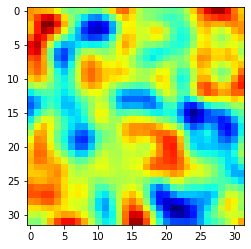

In [16]:
plt.imshow(input_raw[130],cmap='jet')

In [17]:
label_data[130]

array([-2.62578014, -2.69580221,  0.67915201])

In [18]:
print(sigma_min,sigma_max)

0.58 0.93


In [20]:
np.savez("dataML_data2.npz", label=label_data, raw_data=input_raw)